In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import string
import os
import glob
from PIL import Image
from time import time
from tensorflow.python import keras

from keras import Input, layers
from keras import optimizers
#from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.optimizer_v2 import adam
from keras_preprocessing import sequence
from keras_preprocessing import image
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, Bidirectional
#from tensorflow.keras.layers.wrappers import Bidirectional
from keras.layers.merging import add
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
#from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.utils.np_utils import to_categorical

In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [3]:
images_path="../data/image/"
train_images_path="../data/Flickr_30k.trainImages.txt"
test_images_path="../data/Flickr_30k.testImages"
glove_path = '../glove6b_model'

a dictionary named “descriptions” which contains the name of the image as keys and a list of the 5 captions for the corresponding image as values

In [4]:
import csv
descriptions = dict()
file = open('../data/results.csv',encoding="utf8")
csvreader = csv.reader(file)
i=0
for row in csvreader:
    if i!=0:
        id=row[0].split("|")[0].split('.')[0]
        if id not in descriptions:
            descriptions[id] = list()
        descriptions[id].append(row[0].split("|")[-1])
    i+=1

In [5]:
print(len(descriptions.keys()))
with open('Flickr_30k.trainImages.txt', 'w') as f:
    for key in descriptions.keys():
        f.write(key+".jpg"+"\n")

31783


some basic text clean to get rid of punctuation and convert our descriptions to lowercase

In [6]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

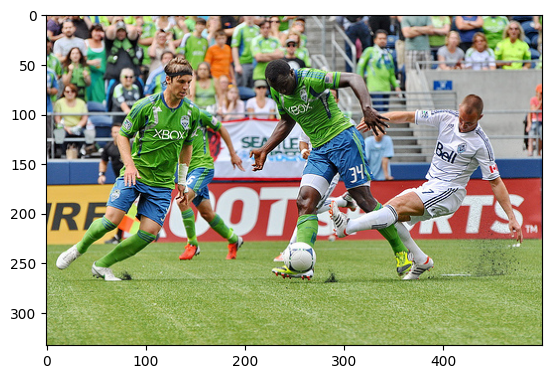

['a soccer player in a white jersey is falling to the ground as players in green jerseys take the ball ',
 'two green shirted soccer players attempt to secure the soccer ball from a player dressed in white ',
 'two soccer teams are competing in a brightlycolored stadium filled with onlookers ',
 'a game of soccer where the opposing team in trying to gain the ball back ',
 'the men are in the middle of a soccer game ']

In [8]:
pic = '7812612114.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['7812612114']

create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions in the data set

In [9]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 18942


 save the image id’s and their new cleaned captions in the same format as the results.csv file

In [10]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)


 load all the training image id’s in a variable train from the ‘Flickr_30k.trainImages.txt’ file

In [17]:
opn = open("../data/Flickr_30k.trainImages.txt",'r').read()
dataset = list()
for line in opn.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

all the training and testing images in train_img and test_img lists

In [18]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

# test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
# test_img = []
# for i in img: 
#     if i[len(images_path):] in test_images: 
#         test_img.append(i)

load the descriptions of the training images into a dictionary

add two tokens in every caption, which are ‘startseq’ and ‘endseq’

In [19]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
            
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

Create a list of all the training captions

In [23]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)


To make our model more robust we will reduce our vocabulary to only those words which occur at least 10 times in the entire corpus

In [24]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 5117


### store it in a file so that we can use it in another file as we have need this one.

In [ ]:
with open('vocab.txt','w') as f:
    for x in vocab:
        f.write('%s\n'%x)

create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length

In [25]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

 max length of a caption

In [26]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 74


# Glove Embeddings

## map all the words in our 74-word long caption to a 100-dimension vector using Glove

In [ ]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.100d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

make the matrix of shape (5118, 100) consisting of our vocabulary and the 100-d vector

In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Model Building and Training

In [16]:
model = InceptionV3(weights='imagenet')

we do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the EfficientNetV2L model.

In [17]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

we are using EfficientNetV2L we need to pre-process our input

preprocess function to reshape the images to (480 x 480)

 feed to the preprocess_input() function of Keras.

In [18]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

encode our training and testing images, i.e extract the images vectors of shape (2048,)

In [19]:
%%time

def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

# encoding_test = {}
# for img in test_img:
#     encoding_test[img[len(images_path):]] = encode(img)

1/1 [==============================] - 2s 2s/step


KeyboardInterrupt: 

let’s define our model.

We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:


Processing the sequence from the text 

Extracting the feature vector from the image

Decoding the output using softmax by concatenating the above two layers

In [ ]:

import pickle5 as pickle
dic=train_features
filehandler = open('feature.pkl', 'wb')
pickle.dump(dic, filehandler)

In [ ]:
infile = open('feature.pkl','rb')
tfs = pickle.load(infile)
infile.close()

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 74, 100)      501800      ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

#  Model Training

### not want to retrain the weights in our embedding layer (pre-trained Glove vectors).

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

## Since our dataset has 30k images, we will create a function that can train the data in batches.

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [1]:
%%time

epochs = 30
batch_size = 256
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

NameError: name 'train_descriptions' is not defined

# Greedy and Beam Search

## model generates a 1660 long vector with a probability distribution across all the words in the vocabulary we greedily pick the word with the highest probability to get the next word prediction. This method is called Greedy Search

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

## Beam Search is where we take top k predictions, feed them again in the model and then sort them using the probabilities returned by the model. So, the list will always contain the top k predictions and we take the one with the highest probability and go through it till we encounter ‘endseq’ or reach the maximum caption length.

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption